In [1]:
from labdata.schema import *
import pylab as plt
%matplotlib widget
from labdata import chronic_paper as paper
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.matplotlib.rcParams['ps.fonttype'] = 42
savepath = Path('../../figures/figure2')
savepath.mkdir(parents = True,exist_ok = True)

loc_subject = 'JC131'
loc_session = '20231012_174050'


[2024-06-10 11:06:43,167][INFO]: Connecting mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-06-10 11:06:43,499][INFO]: Connected mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [ ]:
# get the locomotion traces
key = dict(subject_name = loc_subject,
          session_name = loc_session)
# insert the locomotion session
dat = paper.LocomotionBehaviorTreadmill().insert_session(key)

### Motion estimate for a probe with 2 shanks in cortex and 2 in thalamus. 

Motion estimates on locomoting headfixed mouse. 

In [2]:
shank_num = 0
k = dict(subject_name = loc_subject,
         session_name = loc_session, shank_num = shank_num)

dat = (paper.DredgeSpikeDetection()*paper.DredgeMotionEstimate()*paper.LocomotionBehaviorTreadmill & k).fetch1()

sp = (paper.DredgeSpikeDetection() & k).get_spikes(shank_num = k['shank_num']).iloc[0]

k = dict(subject_name = loc_subject,
         session_name = loc_session)
dat_all = pd.DataFrame((paper.DredgeSpikeDetection()*paper.DredgeMotionEstimate()*paper.LocomotionBehaviorTreadmill & k).fetch())

{'subject_name': 'JC131', 'session_name': '20231012_174050', 'dataset_name': 'ephys_g1', 'probe_num': 0, 'peak_locations': 'JC131/20231012_174050/dredge_spike_detection/probe_0/peak_locations.npy', 'peak_locations_storage': 'analysis', 'peaks': 'JC131/20231012_174050/dredge_spike_detection/probe_0/peaks.npy', 'peaks_storage': 'analysis'}


/tmp/ipykernel_3656834/2517885987.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = np.arange(-5*locrate,10*locrate).astype(int)
/tmp/ipykernel_3656834/2517885987.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  disp_idx = np.arange(-5*disp_rate,11*disp_rate).astype(int)


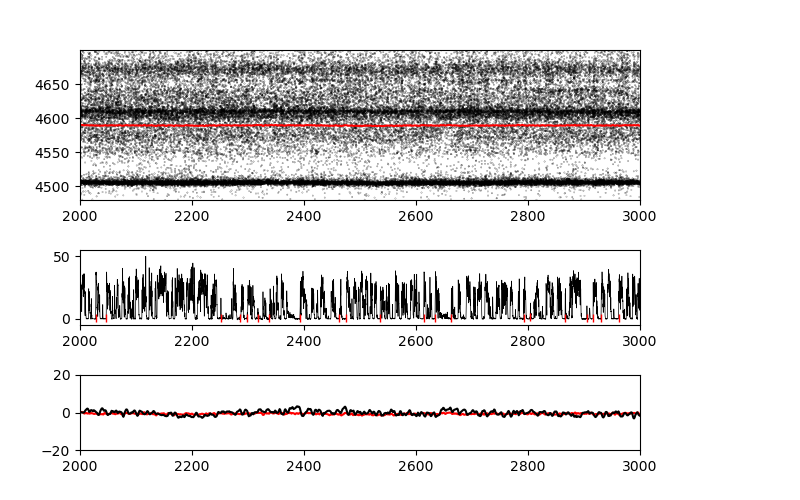

In [3]:
from spks.viz import plot_drift_raster
import pylab as plt
fig = plt.figure(figsize=[8,5])
ax = [fig.add_axes([0.1,0.6,0.7,0.3]),
      fig.add_axes([0.1,0.35,0.7,0.15]),
      fig.add_axes([0.1,0.1,0.7,0.15])]
tt = 2000
ttdur = 1000
max_time = 3600
plt.axes(ax[0])
idx = (sp['t_seconds']>tt) & (sp['t_seconds']<tt+ttdur) & (sp['depth_um']<4700) & (sp['depth_um']>4480)
plot_drift_raster(sp['t_seconds'][idx],
                  sp['depth_um'][idx],
                  sp['amps'][idx]
                  ,n_spikes_to_plot=50000,clim=[0,200],cmap = 'gray_r')
#plt.ylim([4300,4900])
idx = (dat_all['time_bin_centers_s'].iloc[0]>=tt) & (dat_all['time_bin_centers_s'].iloc[0]<(tt+ttdur))
plt.plot(dat_all['time_bin_centers_s'].iloc[0][idx],dat_all['displacement'].iloc[0][idx]+np.mean(plt.ylim()),'r')

# plt.xlim([tt,tt+ttdur])
plt.xlim([tt,tt+ttdur])

plt.axes(ax[1])

time = dat['time'][:-1]
plt.plot(time,dat['velocity'],'k',lw = 0.5)
from scipy.signal import medfilt
loc_binary = (medfilt(dat['velocity'],101)>1).astype(int)
onsets = np.where(np.diff(loc_binary)>0)[0]
offsets = np.where(np.diff(loc_binary)<0)[0]

onsets = onsets[onsets>offsets[0]]
offsets = offsets[offsets<onsets[-1]]
idx = np.where((onsets-offsets)>(5/np.diff(time[:2])))
onsets = onsets[idx]
offsets = offsets[idx]
plt.plot(time[onsets],dat['velocity'][onsets],'r|')
plt.xlim([tt,tt+ttdur])
plt.ylim(-5,55)
plt.axes(ax[2])
plt.plot(dat_all['time_bin_centers_s'].iloc[0],dat_all['displacement'].iloc[0],'r')
plt.plot(dat_all['time_bin_centers_s'].iloc[2],dat_all['displacement'].iloc[2][0],'k')
plt.ylim([-20,20])
plt.xlim([tt,tt+ttdur])
# extract the triggered locations
loc_start = []
disp_start = []
locrate = 1./np.diff(time[:2])
idx = np.arange(-5*locrate,10*locrate).astype(int)
for on in onsets:
    onset = np.where(time>time[on])[0][0]
    if ((onset - idx[0])>0) and ((onset + idx[-1])<len(dat['velocity'])):
        loc_start.append(dat['velocity'][onset+idx])

for i,dat in dat_all.iterrows():
    disp = dat['displacement']
    if len(disp.shape) == 2:
        disp = disp[-1]
    disp_t = dat['time_bin_centers_s']
    disp_rate = 1./np.diff(disp_t[:2])
    disp_idx = np.arange(-5*disp_rate,11*disp_rate).astype(int)
    disp_start.append([])
    for on in onsets:
        onset = np.where(disp_t>time[on])[0][0]
        if ((onset - disp_idx[0])>0) and ((onset + disp_idx[-1])<len(disp)):
            disp_start[-1].append(disp[onset+disp_idx])
plt.savefig(savepath/'figure2_locomotion_raster.pdf')

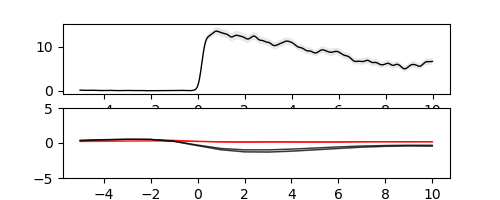

In [4]:
fig = plt.figure(figsize = [5,2])
fig.add_subplot(2,1,1)
def plot_mean_and_sterr(time,dat,color = 'k',facecolor = 'lightgray',fillalpha = 0.5,linealpha = 1,lw = 1):
    m = dat.mean(axis = 0)
    s = dat.std(axis = 0)/np.sqrt(len(dat))    

    plt.fill_between(time,m+s,m-s,facecolor = facecolor,alpha = fillalpha)
    plt.plot(time,m,color = color,alpha = linealpha,lw = lw)

plot_mean_and_sterr(idx/locrate,np.stack(loc_start))
fig.add_subplot(2,1,2)
for i,disp in enumerate(disp_start):
    d = np.stack(disp)
    #plot_mean_and_sterr(disp_idx/disp_rate,d)
    if i>=2:
        plot_mean_and_sterr(disp_idx/disp_rate,d,color = 'k',facecolor = 'gray',linealpha = 0.7)
    else:
        plot_mean_and_sterr(disp_idx/disp_rate,d,color = 'r',facecolor = 'red',linealpha = 0.7)
plt.ylim(-5,5)
# disp_start2 = np.stack(disp_start2)
# plt.plot(disp_idx/disp_rate,disp_start2.T,'r',lw = 0.1);
# plt.plot(disp_idx/disp_rate,disp_start2.mean(axis = 0),'r',lw = 1);
plt.savefig(savepath/'figure2_locomotion_triggered.pdf')

# comparisson of acute and chronic on approximately the same insertions.


In [5]:
np.timedelta64((datetime(2023,10,26) - datetime(2023,8,10))).astype('timedelta64[W]')

numpy.timedelta64(11,'W')

In [18]:
# SUBJECTS = ['_CSH_ZAD_026','_CSH_ZAD_026','MM008','MM008','MM012','MM012']
# SESSIONS = ['2020-08-15/001',
#             '2020-08-19/001',
#             '2023-03-23/001',
#             '2023-06-09/001',
#             '2023-08-15/001',
#             '2023-10-25/003']
# PROBENUM = [0,0,1,1,1,1]

labels = ['Acute session 1',
          'Acute session 2',
          'Chronic implant 1\nWeek 1',
          'Chronic implant 1\nWeek 11',
          'Chronic implant 2\nWeek 1',
          'Chronic implant 2\nWeek 11',]

SUBJECTS = ['_CSH_ZAD_026','_CSH_ZAD_026','MM008','MM008','MM012','MM012']
SESSIONS = ['2020-08-15/001',
            '2020-08-19/001',
            '2023-03-23/001',
            '2023-06-07/001',
            '2023-08-10/001',
            '2023-10-26/001']
PROBENUM = [0,0]+[1]*4


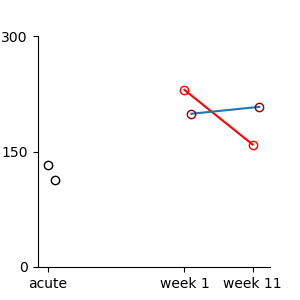

In [23]:
unit_criteria_id = 1
parameter_set_num = 5
keys = []
for a,s,p in zip(SUBJECTS,SESSIONS,PROBENUM):
    keys.append(dict(subject_name = a,
                    session_name = s,
                    probe_num = p,
                    unit_criteria_id = unit_criteria_id,
                    parameter_set_num = parameter_set_num))
suas = pd.DataFrame((UnitCount() & keys).fetch())
fig = plt.figure(figsize = [3,3])
plt.plot([1,1.1],suas.sua.values[[0,1]],'ko',markerfacecolor = 'none')
plt.plot([3,4],suas.sua.values[[2,3]],'ro-',markerfacecolor = 'none')
plt.plot([3.1,4.1],suas.sua.values[[4,5]],'o-',markeredgecolor = 'darkred',markerfacecolor = 'none')

plt.ylim([0,200])
plt.yticks([0,150,300])
plt.xticks([1,3,4],['acute','week 1','week 11'])
plt.gca().spines[['right', 'top']].set_visible(False)
plt.savefig(savepath/'figure2_SUA_count.pdf')

In [26]:
dat.shape

(6, 11)

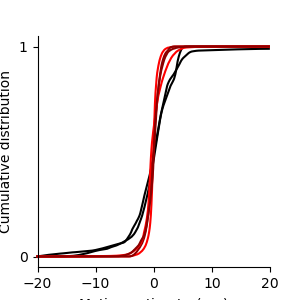

In [25]:
# Motion
dat = pd.DataFrame((paper.DredgeMotionEstimate() & 'shank_num = 0' & keys).fetch())
from scipy.signal import detrend
fig = plt.figure(figsize = [3,3])
for i,d in enumerate(dat.displacement.values):
    if i < 2:
        c = 'k'
    elif i in [2,4]:
        c = 'r'
    else:
        c = 'darkred'
    # plt.plot(np.abs(detrend(d.T,axis = 0)),c)
    edges = np.arange(-20,20,0.1)
    count,ed = np.histogram(d.flatten(),edges)
    plt.plot(ed[:-1],np.cumsum(count)/len(d.flatten()),color = c,clip_on = False)
plt.xlabel('Motion estimate ($\mu$m)')
plt.ylabel('Cumulative distribution')
plt.yticks([0,1])
#plt.ylim([0,1])
plt.xlim([-20,20])
plt.gca().spines[['right', 'top']].set_visible(False)
plt.savefig(savepath/'figure2_motion_compare.pdf')

In [31]:
# run stats on distributions
import numpy as np
from scipy.stats import fligner

for i,d1 in enumerate(dat.displacement.values):
    for j,d2 in enumerate(dat.displacement.values[i+1:]):
        d1 = np.histogram(d1.flatten(),edges)[0]
        d2 = np.histogram(d2.flatten(),edges)[0]
        _,p = fligner(d1,d2)
        print(f'P val for session {i} and {i+j+1} is {p}')


P val for session 0 and 1 is 0.38643388157459446
P val for session 0 and 2 is 5.341456628350944e-14
P val for session 0 and 3 is 1.861743305016683e-15
P val for session 0 and 4 is 4.847065951915021e-90
P val for session 0 and 5 is 3.873079190520427e-40
P val for session 1 and 2 is 1.1238897545331346e-40
P val for session 1 and 3 is 5.746131379165921e-14
P val for session 1 and 4 is 1.4383190369380736e-89
P val for session 1 and 5 is 8.70003844548705e-40
P val for session 2 and 3 is 0.7442704833659406
P val for session 2 and 4 is 5.701584523924187e-86
P val for session 2 and 5 is 1.318893720153695e-39
P val for session 3 and 4 is 1.1426969991338131e-24
P val for session 3 and 5 is 2.2748481881215687e-37
P val for session 4 and 5 is 1.2506490741635766e-07


In [ ]:
data = pd.DataFrame((UnitMetrics* UnitCount.Unit & keys).fetch())
# get sua amplitudes for all units
ampsua = []
amps = []
for a,s in zip(SUBJECTS,SESSIONS):
    idx = np.where((data['subject_name'] == a) & (data['session_name']==s) & (data['passes'] == 1))[0]
    ampsua.append(data['spike_amplitude'].values[idx])
    
    idx = np.where((data['subject_name'] == a) & (data['session_name']==s) & (data['passes'] == 0))[0]
    amps.append(-data['spike_amplitude'].values[idx][np.isfinite(data['spike_amplitude'].values[idx])])
fig = plt.figure(figsize = [5,2])
vsua = plt.violinplot(ampsua,showmedians= True);
vmua = plt.violinplot(amps,showmedians= True);
for i,(u,a) in enumerate(zip(ampsua,amps)):
    plt.text(i+1.15,500, f'{len(u)} sua',rotation = 90)
    plt.text(i+1.15,-500, f'{len(a)} mua',rotation = 90)
for i,b in enumerate(vsua['bodies']):
    if i < 2:
        c = 'k'
    elif i in [2,4]:
        c = 'r'
    else:
        c = 'darkred'
    b.set_edgecolor(c)
    b.set_facecolor('lightgray')
    b.set_alpha(1)
vsua['cmedians'].set_color('k')
vsua['cbars'].set_color('k')
vsua['cmins'].set_color('k')
vsua['cmaxes'].set_color('k')

for i,b in enumerate(vmua['bodies']):
    if i < 2:
        c = 'k'
    elif i in [2,4]:
        c = 'r'
    else:
        c = 'darkred'
    b.set_edgecolor(c)
    b.set_facecolor('lightgray')
    b.set_alpha(1)
vmua['cmedians'].set_color('k')
vmua['cbars'].set_color('k')
vmua['cmins'].set_color('k')
vmua['cmaxes'].set_color('k')
plt.ylim([-1000,1000])
plt.yticks([-500,0,500])
plt.ylabel('Absolute spike amplitude ($\mu$V)')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.savefig(savepath/'figure2_spike_amplitudes.pdf')

In [ ]:
# stats for spike amplitudes
from scipy.stats import f_oneway, tukey_hsd

stat,p = f_oneway(*amps) # ANOVA
print(p)
stat,p = f_oneway(*ampsua) # ANOVA
print(p)

# tukey post ho
amps_rez = tukey_hsd(*amps)
sua_amps_rez = tukey_hsd(*ampsua)
for i in range(len(amps)):
    for j in range(i+1,len(amps)):
        print(f'P value for session {i} and {j} is {amps_rez.pvalue[i,j]} (multi-unit)')
        print(f'P value for session {i} and {j} is {sua_amps_rez.pvalue[i,j]} (single-unit)')

### Comparison of units passing with different criteria

In [ ]:
for k in keys:
    if 'unit_criteria_id' in k.keys():
        del k['unit_criteria_id']
d1 = pd.DataFrame((UnitCount() & keys & 'unit_criteria_id = 1').fetch())
d2 = pd.DataFrame((UnitCount() & keys & 'unit_criteria_id = 6').fetch())
fig = plt.figure(figsize = [4,4])
fig.add_axes([0.2,0.2,0.6,0.6])
plt.scatter(d2.sua.values,d1.sua.values,100,['k','k','r','darkred','red','darkred'],alpha = 0.8,marker = 'o')
plt.axis('square')
plt.xlim(80,320)
plt.ylim(80,320)
plt.plot([80,320],[80,320],'k',lw = 0.5)
plt.yticks([100,200,300],fontsize=8)
plt.xticks([100,200,300],fontsize=8)
plt.plot(d2.sua.values[2:4],d1.sua.values[2:4],lw = 0.5,color='k')
plt.plot(d2.sua.values[4:6],d1.sua.values[4:6],lw = 0.5,color='k')
plt.ylabel('# passing units\n(presence > 60%)', fontsize=12)
plt.xlabel('# passing units\n(presence > 0%)',fontsize = 12)
plt.savefig(savepath/'figure2_presence_ratio.pdf')

In [89]:
print('Chronic:',np.mean(d2.sua.values[2:]-d1.sua.values[2:]),np.std(d2.sua.values[2:]-d1.sua.values[2:])/np.sqrt(4))
print('Acute',np.mean(d2.sua.values[:2]-d1.sua.values[:2]),np.std(d2.sua.values[:2]-d1.sua.values[:2])/np.sqrt(2))

Chronic: 50.5 2.704163456597992
Acute 78.5 3.8890872965260113
